# Image classification

## Plan
- seed = 7 
- All data exists in `dataset/images` directory.
- Separate 10% for test dataset.
    - Store test dataset under `dataset/test`
    - Store `inputDataset = (dataset - test)` under `dataset/input`
- Use Stratified 10-fold cross validation to divide `inputDataset` dataset into:
    - `train` datasets 
    - `val` datasets
- Train
    - Shuffle `train` dataset
    - Use `train` dataset to train your model, with validation_split=0.1
    - Evalaute in each epoch on `val` dataset

```
from sklearn.model_selection import train_test_split

x_input, x_test, y_input, y_test = train_test_split(xs, ys,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    stratify=ys)

shuffle(x_input, y_input)

# X_train = 
# Y_train = 

validation_split = 0.1

for train_set, validation_set in rkf.split(x_input, y_input):
    X_train, X_val = x_input[train_set], x_input[validation_set]
    Y_train, Y_val = y_input[train_set], y_input[validation_set]

    model.fit(X_train, Y_train, epochs=n_epochs, verbose=0,
                              validation_split=validation_split)
                              
    model.evaluate(X_val, Y_val)
    
# Now run once after long tuning
model.evaluate(x_test, y_test)
```

## Imports

In [1]:
import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree


import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.common_utils as cm



import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from os import listdir
from os.path import isfile, join


%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

None


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

# Global variables

In [3]:
oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input/"
test_images_src = "dataset/test/"
model_results_root_dir = "img_model2/"

input_images_classified = "dataset/input-classified/"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits = 1# 10 #10

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs = 1#50 # 3
patience = 10 # ReduceLROnPlateau has 5
batch_size = 32 # 32  
FC_SIZE = 1024
LAYERS_TO_FREEZE = 249
img_height = 299
img_width = 299

useF1Score = False
verbose=1 



## Creating test and input dataset, and `positive,neutral,negative` under each dataset

In [4]:
image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)

image_names = np.array(image_names)
image_labels = np.array(image_labels)

input_x, test_x, input_y,  test_y = train_test_split(image_names, image_labels,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=image_labels)

print("Input data (to be used for model learning and validation) label distribution: \n",pt.get_label_count(input_y))
print()
print("Test data(never used for learning) label distribution: \n",pt.get_label_count(test_y))


# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)


# Copy input images into input dir, and test images into test dir
cm.copy_imgs_into(oasis_images_src, input_x, input_images_src)
cm.copy_imgs_into(oasis_images_src, test_x, test_images_src)



Input data (to be used for model learning and validation) label distribution: 
 OrderedDict([('negative', 147), ('neutral', 378), ('positive', 285)])

Test data(never used for learning) label distribution: 
 OrderedDict([('negative', 16), ('neutral', 42), ('positive', 32)])


config:
 {'img_height': 299, 'img_width': 299, 'kfold_splits': 10, 'batch_size': 32, 'nb_epochs': 50, 'useF1Score': False, 'verbose': 1}
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/50
22/22 [==============================] - 25s 1s/step - loss: 1.0719 - acc: 0.4191 - val_loss: 1.0715 - val_acc: 0.5000
Epoch 2/50
22/22 [==============================] - 15s 692ms/step - loss: 1.0346 - acc: 0.4782 - val_loss: 1.0686 - val_acc: 0.5156
Epoch 3/50
22/22 [==============================] - 15s 686ms/step - loss: 1.0205 - acc: 0.4801 - val_loss: 1.0724 - val_acc: 0.4531
Epoch 4/50
22/22 [==============================] - 15s 678ms/step - loss: 1.0016 - acc: 0.5114 - val_loss: 1.0288 - val_acc: 0.5625
Epoch 5/50
22/22 [==============================] - 15s 672ms/step - loss: 0.9775 - acc: 0.5247 - val_loss: 1.0400 - val_acc: 0.5625
Epoch 6/50
22/22 [==============================] - 15s 666ms/step - loss: 0.9702 - acc: 0.5317 - val_loss: 1.0050 - val_acc: 0.5938
Epoch 7/50
22/22 [==============================] - 15s 669ms/step - loss: 0.9512 - acc: 0.5572 - val_loss: 1.0218 - val_acc: 0.5781
Epoch 8/50
22/22 [==============================] - 15s 675ms/step - los

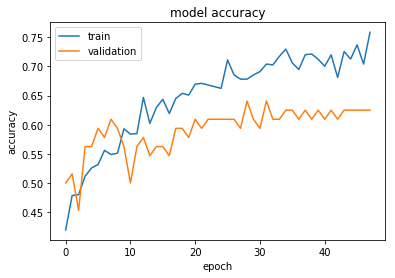

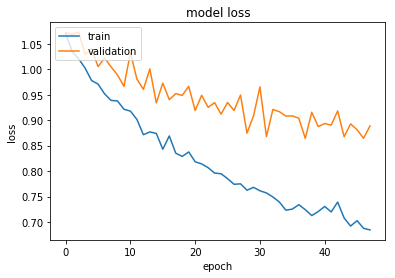

best_val_acc 0.640625
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 41s 2s/step - loss: 1.0951 - acc: 0.4357 - val_loss: 1.0017 - val_acc: 0.5781
Epoch 2/50
22/22 [==============================] - 26s 1s/step - loss: 1.0350 - acc: 0.4759 - val_loss: 1.0130 - val_acc: 0.5781
Epoch 3/50
22/22 [==============================] - 26s 1s/step - loss: 1.0202 - acc: 0.4966 - val_loss: 0.9927 - val_acc: 0.5938
Epoch 4/50
22/22 [==============================] - 26s 1s/step - loss: 1.0083 - acc: 0.5150 - val_loss: 0.9731 - val_acc: 0.5781
Epoch 5/50
22/22 [==============================] - 26s 1s/step - loss: 0.9793 - acc: 0.5375 - val_loss: 0.9643 - val_acc: 0.6406
Epoch 6/50
22/22 [=========

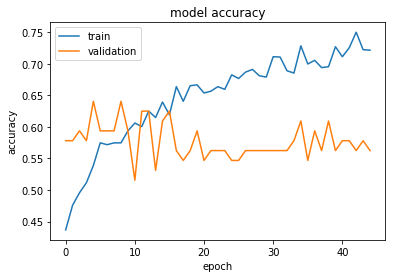

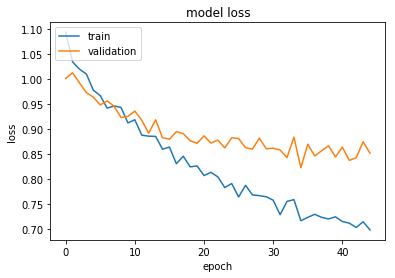

best_val_acc 0.640625
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 45s 2s/step - loss: 1.0816 - acc: 0.3840 - val_loss: 1.0789 - val_acc: 0.5312
Epoch 2/50
22/22 [==============================] - 26s 1s/step - loss: 1.0433 - acc: 0.4631 - val_loss: 1.0718 - val_acc: 0.5312
Epoch 3/50
22/22 [==============================] - 26s 1s/step - loss: 1.0320 - acc: 0.4625 - val_loss: 1.0733 - val_acc: 0.5156
Epoch 4/50
22/22 [==============================] - 25s 1s/step - loss: 1.0133 - acc: 0.4716 - val_loss: 1.0242 - val_acc: 0.5312
Epoch 5/50
22/22 [==============================] - 26s 1s/step - loss: 0.9919 - acc: 0.5014 - val_loss: 1.0380 - val_acc: 0.5156
Epoch 6/50
22/22 [=========

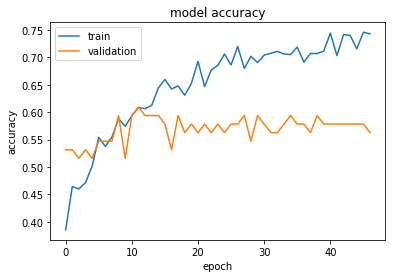

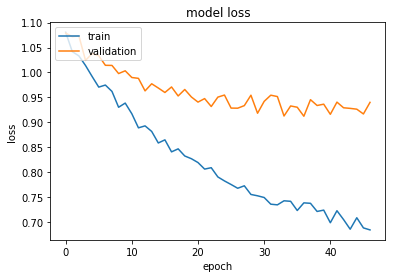

best_val_acc 0.609375
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 49s 2s/step - loss: 1.0764 - acc: 0.4474 - val_loss: 1.1158 - val_acc: 0.4688
Epoch 2/50
22/22 [==============================] - 25s 1s/step - loss: 1.0525 - acc: 0.4550 - val_loss: 1.1022 - val_acc: 0.4844
Epoch 3/50
22/22 [==============================] - 25s 1s/step - loss: 1.0293 - acc: 0.4697 - val_loss: 1.0720 - val_acc: 0.5000
Epoch 4/50
22/22 [==============================] - 25s 1s/step - loss: 1.0245 - acc: 0.4754 - val_loss: 1.0849 - val_acc: 0.5000
Epoch 5/50
22/22 [==============================] - 25s 1s/step - loss: 0.9931 - acc: 0.5233 - val_loss: 1.0468 - val_acc: 0.5156
Epoch 6/50
22/22 [=========

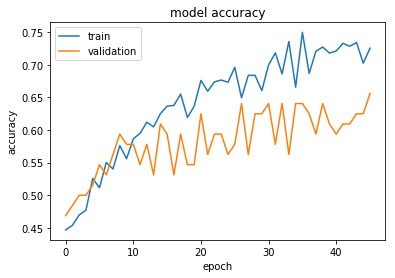

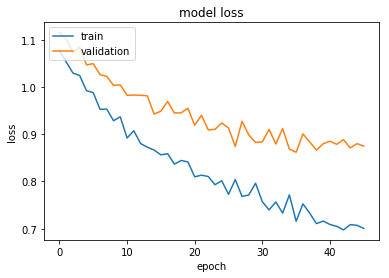

best_val_acc 0.65625
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 62s 3s/step - loss: 1.0775 - acc: 0.4460 - val_loss: 1.0901 - val_acc: 0.4531
Epoch 2/50
22/22 [==============================] - 25s 1s/step - loss: 1.0499 - acc: 0.4540 - val_loss: 1.0775 - val_acc: 0.4844
Epoch 3/50
22/22 [==============================] - 25s 1s/step - loss: 1.0371 - acc: 0.4901 - val_loss: 1.0573 - val_acc: 0.5156
Epoch 4/50
22/22 [==============================] - 24s 1s/step - loss: 1.0213 - acc: 0.5120 - val_loss: 1.0401 - val_acc: 0.5156
Epoch 5/50
22/22 [==============================] - 25s 1s/step - loss: 0.9888 - acc: 0.5308 - val_loss: 1.0268 - val_acc: 0.5312
Epoch 6/50
22/22 [==========

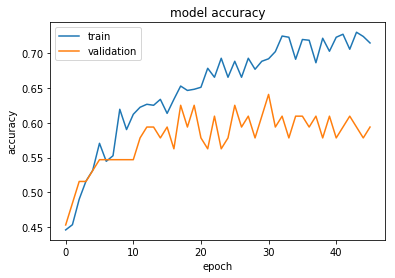

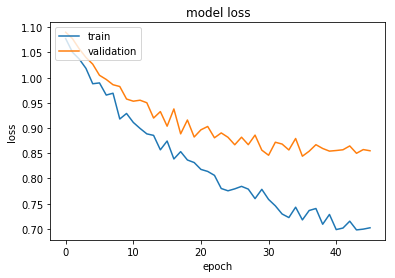

best_val_acc 0.640625
Train size:  729
Val size:  81
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 28)])
Found 729 images belonging to 3 classes.
Found 81 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 63s 3s/step - loss: 1.0863 - acc: 0.3882 - val_loss: 1.0634 - val_acc: 0.4844
Epoch 2/50
22/22 [==============================] - 25s 1s/step - loss: 1.0330 - acc: 0.4888 - val_loss: 1.0807 - val_acc: 0.4688
Epoch 3/50
22/22 [==============================] - 26s 1s/step - loss: 1.0302 - acc: 0.4775 - val_loss: 1.0311 - val_acc: 0.5469
Epoch 4/50
22/22 [==============================] - 25s 1s/step - loss: 1.0147 - acc: 0.5037 - val_loss: 1.0423 - val_acc: 0.5000
Epoch 5/50
22/22 [==============================] - 26s 1s/step - loss: 0.9831 - acc: 0.5332 - val_loss: 0.9999 - val_acc: 0.5469
Epoch 6/50
22/22 [=========

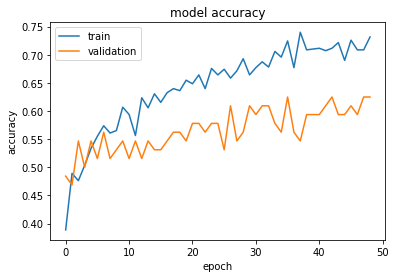

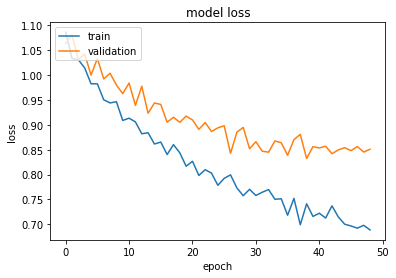

best_val_acc 0.625
Train size:  729
Val size:  81
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 28)])
Found 729 images belonging to 3 classes.
Found 81 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 69s 3s/step - loss: 1.0582 - acc: 0.4369 - val_loss: 1.0633 - val_acc: 0.5000
Epoch 2/50
22/22 [==============================] - 26s 1s/step - loss: 1.0316 - acc: 0.4790 - val_loss: 1.0459 - val_acc: 0.5156
Epoch 3/50
22/22 [==============================] - 26s 1s/step - loss: 1.0117 - acc: 0.5104 - val_loss: 1.0474 - val_acc: 0.4844
Epoch 4/50
22/22 [==============================] - 25s 1s/step - loss: 0.9983 - acc: 0.5114 - val_loss: 1.0251 - val_acc: 0.5156
Epoch 5/50
22/22 [==============================] - 25s 1s/step - loss: 0.9894 - acc: 0.5651 - val_loss: 1.0042 - val_acc: 0.5781
Epoch 6/50
22/22 [============

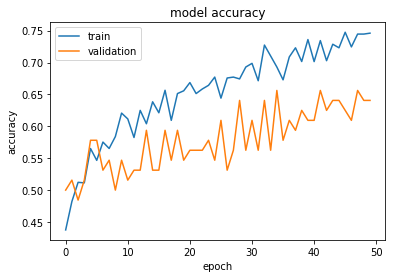

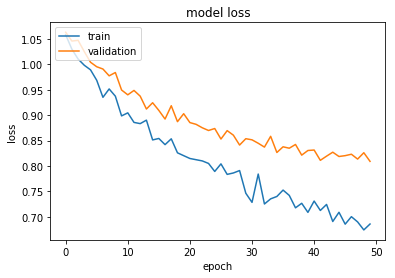

best_val_acc 0.65625
Train size:  730
Val size:  80
Train label distribution:  OrderedDict([('negative', 133), ('neutral', 340), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 14), ('neutral', 38), ('positive', 28)])
Found 730 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 80s 4s/step - loss: 1.0944 - acc: 0.3982 - val_loss: 0.9849 - val_acc: 0.5938
Epoch 2/50
22/22 [==============================] - 26s 1s/step - loss: 1.0619 - acc: 0.4348 - val_loss: 0.9663 - val_acc: 0.5938
Epoch 3/50
22/22 [==============================] - 25s 1s/step - loss: 1.0220 - acc: 0.4722 - val_loss: 0.9662 - val_acc: 0.5938
Epoch 4/50
22/22 [==============================] - 26s 1s/step - loss: 1.0254 - acc: 0.4588 - val_loss: 0.9448 - val_acc: 0.6094
Epoch 5/50
22/22 [==============================] - 26s 1s/step - loss: 1.0043 - acc: 0.4927 - val_loss: 0.9306 - val_acc: 0.6250
Epoch 6/50
22/22 [==========

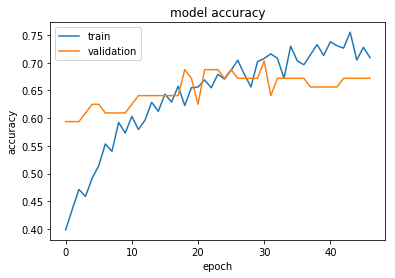

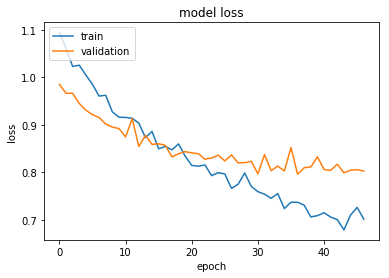

best_val_acc 0.703125
Train size:  731
Val size:  79
Train label distribution:  OrderedDict([('negative', 133), ('neutral', 341), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 14), ('neutral', 37), ('positive', 28)])
Found 731 images belonging to 3 classes.
Found 79 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 88s 4s/step - loss: 1.0987 - acc: 0.3893 - val_loss: 1.0172 - val_acc: 0.5312
Epoch 2/50
22/22 [==============================] - 26s 1s/step - loss: 1.0405 - acc: 0.4674 - val_loss: 1.0293 - val_acc: 0.5156
Epoch 3/50
22/22 [==============================] - 26s 1s/step - loss: 1.0363 - acc: 0.4790 - val_loss: 1.0182 - val_acc: 0.5312
Epoch 4/50
22/22 [==============================] - 26s 1s/step - loss: 1.0149 - acc: 0.5087 - val_loss: 1.0186 - val_acc: 0.5156
Epoch 5/50
22/22 [==============================] - 25s 1s/step - loss: 0.9735 - acc: 0.5459 - val_loss: 1.0045 - val_acc: 0.5312
Epoch 6/50
22/22 [=========

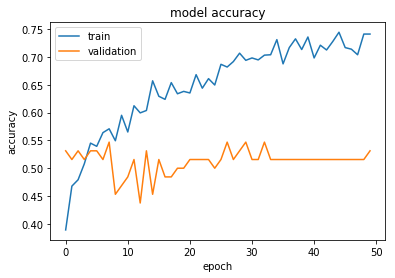

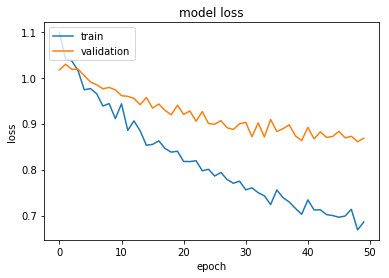

best_val_acc 0.546875
Train size:  731
Val size:  79
Train label distribution:  OrderedDict([('negative', 133), ('neutral', 341), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 14), ('neutral', 37), ('positive', 28)])
Found 731 images belonging to 3 classes.
Found 79 images belonging to 3 classes.
Epoch 1/50
22/22 [==============================] - 76s 3s/step - loss: 1.0595 - acc: 0.4395 - val_loss: 1.0510 - val_acc: 0.5156
Epoch 2/50
22/22 [==============================] - 15s 699ms/step - loss: 1.0309 - acc: 0.4774 - val_loss: 1.0326 - val_acc: 0.5000
Epoch 3/50
22/22 [==============================] - 15s 684ms/step - loss: 1.0191 - acc: 0.4648 - val_loss: 1.0199 - val_acc: 0.5000
Epoch 4/50
22/22 [==============================] - 15s 678ms/step - loss: 0.9889 - acc: 0.4984 - val_loss: 1.0209 - val_acc: 0.5156
Epoch 5/50
22/22 [==============================] - 15s 688ms/step - loss: 0.9999 - acc: 0.5013 - val_loss: 1.0034 - val_acc: 0.5000
Epoch 6/50
22/2

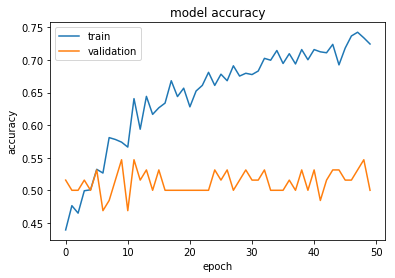

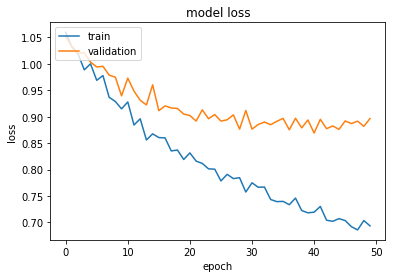

best_val_acc 0.546875
Cross-validation val accuracy results:  [0.640625, 0.640625, 0.609375, 0.65625, 0.640625, 0.625, 0.65625, 0.703125, 0.546875, 0.546875]
Cross-validation val accuracy results: 0.63% (+/- 0.05%)


TypeError: must be str, not int

In [8]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
cv_accuracies = []
cv_f1s = []
    
X = input_x
y = input_y
    
# Shuffe input data
X, y = shuffle(X,y)

def get_adam_optimizer():
    return optimizers.Adam(lr=1e-5)

def setup_to_finetune(model, useF1Score):
    """Freeze the bottom LAYERS_TO_FREEZE and retrain the remaining top layers.
  note: LAYERS_TO_FREEZE corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """    
    print("LAYERS_TO_FREEZE:", LAYERS_TO_FREEZE)
    for layer in model.layers[:LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=get_adam_optimizer(), loss='categorical_crossentropy',\
                  metrics=cm.get_metrics(useF1Score))

def setup_to_transfer_learn(model, base_model, useF1Score):
    """Freeze all layers and compile the model"""    
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=get_adam_optimizer(), loss='categorical_crossentropy', metrics=cm.get_metrics(useF1Score))


def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
      Args:
        base_model: keras model excluding top
        nb_classes: # of classes
      Returns:
        new keras model with last layer
    """
    # 62,65,67% w/o reducing lr
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    output_layer = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=output_layer)

#     x = base_model.output
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
#     output_layer = Dense(nb_classes, activation='softmax', name='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output_layer)

    return model




def train(trainDir, valDir, config): 
    """Use transfer learning and fine-tuning to train a network on a new dataset"""     
    
    nb_classes = len(glob.glob(trainDir + "/*"))
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    isForTrain = True
    train_batches = cm.get_data_generator(trainDir, config, isForTrain)  
    

    # this is a similar generator, for validation data
    isForTrain = False
    validation_batches = cm.get_data_generator(valDir, config, isForTrain)  
        
    # setup model
    #base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(config['img_height'],config['img_width'],3))
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model, config['useF1Score'])
    
    # monitor='val_loss', patience = 5 default
    reduce_lr = ReduceLROnPlateau()
    
    filepath = model_results_root_dir + "image.weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)    
    callbacks_list = [ early_stopping, reduce_lr]  # , checkpoint

    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_batches,
            steps_per_epoch= train_batches.samples // config['batch_size'],
            epochs=config['nb_epochs'],
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'],
            shuffle=True,
            verbose=config['verbose'],
            callbacks=callbacks_list,
            class_weight='auto')
    
#     # fine-tuning
#     print("Starting fune-tuning")
#     setup_to_finetune(model, config['useF1Score'])
    
#     callbacks_list.append(checkpoint)
#     history = model.fit_generator(
#             train_generator,
#             steps_per_epoch= 2000 // config['batch_size'],
#             epochs=config['nb_epochs'] * 3,
#             validation_data=validation_generator,
#             validation_steps= 800 // config['batch_size'],
#             shuffle=True,
#             verbose=config['verbose'],
#             callbacks=callbacks_list,
#             class_weight='auto')
    return history, model



def prepare_and_train(config):
    bestModel = None
    final_model_val_acc = -1
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("Train size: ", len(train_indices))
        print("Val size: ", len(val_indices))

        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        print("Train label distribution: ", pt.get_label_count(y_train))
        print("Val label distribution: ", pt.get_label_count(y_val))

        # Divide input images into train and dev set, and each one into {negative, neutral, positive}
        dt.create_cross_validation_train_val("train", input_images_src, input_images_classified, X_train, y_train)
        dt.create_cross_validation_train_val("val", input_images_src, input_images_classified, X_val, y_val)

        trainDir = input_images_classified + "/" + "train" + "/"
        valDir = input_images_classified + "/" + "val" + "/"

        history, model = train(trainDir, valDir, config)
        
        pt.plot_model_accuracy(history, model_results_root_dir, useF1Score)
        best_val_acc = max(history.history['val_acc'])
        
        if best_val_acc > final_model_val_acc:
            bestModel = model
        
        cv_accuracies.append(best_val_acc)
        print("best_val_acc", best_val_acc)
        if useF1Score:
            best_val_f1 = max(history.history['val_f1'])
            cv_f1s.append(best_val_f1)

    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

    if useF1Score:
        print("\n","Cross-validation val f1 results: " , cv_f1s)
        print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))   
    model.save("model/bestmodel-" + str(final_model_val_acc) + ".h5")
    
    # Evaluate Test set
    model.evaluate(test_x, test_y, verbose=1)

def get_config():
    conf = {}
    conf["img_height"] = img_height
    conf["img_width"] = img_width
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    return conf    
    
def main():
    config = get_config()
    print("config:\n", config)
    prepare_and_train(config)
    # predict()
    # text_pre_processing("hello&nbsp;hi")
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()


